# Bands Workflows


In [1]:
from local_module import load_temp_profile
from aiida import engine, orm, plugins
data = load_temp_profile()

In [2]:
%verdi status --no-rmq

 ✔ version:     AiiDA v2.0.4
 ✔ config:      /Users/chrisjsewell/Documents/GitHub/aiida-qe-demo/tutorial/_aiida_path/.aiida
 ✔ profile:     temp_profile
 ✔ storage:     SqliteTemp storage [open], sandbox: /Users/chrisjsewell/Documents/GitHub/aiida-qe-demo/tutorial/_aiida_path/.aiida/repository/temp_profile
 ⏺ daemon:      The daemon is not running


In [3]:
%verdi storage info --detailed

entities:
  Users:
    count: 1
    emails:
    - user@email.com
  Computers:
    count: 1
    labels:
    - local_direct
  Nodes:
    count: 87
    node_types:
    - data.core.code.Code.
    - data.core.structure.StructureData.
    - data.pseudo.upf.UpfData.
    process_types: []
  Groups:
    count: 1
    type_strings:
    - pseudo.family.sssp
  Comments:
    count: 0
  Logs:
    count: 0
  Links:
    count: 0



In [4]:
PwBandsWorkChain = plugins.WorkflowFactory("quantumespresso.pw.bands")
builder = PwBandsWorkChain.get_builder_from_protocol(
    code=data.pw_code, structure=data.si, protocol="fast"
)
builder

Process class: PwBandsWorkChain
Inputs:
bands:
  metadata: {}
  pw:
    code: pw.x code on local computer
    metadata:
      options:
        max_wallclock_seconds: 43200
        resources:
          num_machines: 1
        stash: {}
        withmpi: true
    parameters:
      CONTROL:
        calculation: scf
        etot_conv_thr: 0.0002
        forc_conv_thr: 0.001
        tprnfor: true
        tstress: true
      ELECTRONS:
        conv_thr: 8.0e-10
        electron_maxstep: 80
        mixing_beta: 0.4
      SYSTEM:
        degauss: 0.01
        ecutrho: 240.0
        ecutwfc: 30.0
        nosym: false
        occupations: smearing
        smearing: cold
    pseudos:
      Si: ''
bands_kpoints_distance: 0.1
clean_workdir: true
metadata: {}
nbands_factor: 3.0
relax:
  base:
    kpoints_distance: 0.5
    kpoints_force_parity: false
    metadata: {}
    pw:
      code: pw.x code on local computer
      metadata:
        options:
          max_wallclock_seconds: 43200
          resour

In [5]:
result = engine.run_get_node(builder)
result

Report: [104|PwBandsWorkChain|run_relax]: launching PwRelaxWorkChain<106>
Report: [106|PwRelaxWorkChain|run_relax]: launching PwBaseWorkChain<109>
Report: [109|PwBaseWorkChain|run_process]: launching PwCalculation<114> iteration #1
Report: [109|PwBaseWorkChain|results]: work chain completed after 1 iterations
Report: [109|PwBaseWorkChain|on_terminated]: remote folders will not be cleaned
Report: [106|PwRelaxWorkChain|inspect_relax]: after iteration 1 cell volume of relaxed structure is 40.97320472110393
Report: [106|PwRelaxWorkChain|run_relax]: launching PwBaseWorkChain<123>
Report: [123|PwBaseWorkChain|run_process]: launching PwCalculation<128> iteration #1
Report: [123|PwBaseWorkChain|results]: work chain completed after 1 iterations
Report: [123|PwBaseWorkChain|on_terminated]: remote folders will not be cleaned
Report: [106|PwRelaxWorkChain|inspect_relax]: after iteration 2 cell volume of relaxed structure is 41.15161590466905
Report: [106|PwRelaxWorkChain|inspect_relax]: relative c

ResultAndNode(result={'primitive_structure': <StructureData: uuid: 95409e13-acd3-4005-9d66-20c68f2d7798 (pk: 138)>, 'seekpath_parameters': <Dict: uuid: fbfce900-9811-4c3c-90ad-770785eb0f89 (pk: 136)>, 'scf_parameters': <Dict: uuid: 9c929d8a-5ddb-476e-bb3b-0e414dacd168 (pk: 152)>, 'band_parameters': <Dict: uuid: 7c40102f-0b38-4cae-a71a-a55a74fb753d (pk: 163)>, 'band_structure': <BandsData: uuid: 8314b021-ef4e-47d7-b8bc-5f11d296216a (pk: 161)>}, node=<WorkChainNode: uuid: d7cffad3-7434-4458-a842-121433083b29 (pk: 104) (aiida.workflows:quantumespresso.pw.bands)>)

In [6]:
%verdi process status {result.node.pk}

PwBandsWorkChain<104> Finished [0] [7:results]
    ├── PwRelaxWorkChain<106> Finished [0] [3:results]
    │   ├── PwBaseWorkChain<109> Finished [0] [4:results]
    │   │   ├── create_kpoints_from_distance<110> Finished [0]
    │   │   └── PwCalculation<114> Finished [0]
    │   └── PwBaseWorkChain<123> Finished [0] [4:results]
    │       ├── create_kpoints_from_distance<124> Finished [0]
    │       └── PwCalculation<128> Finished [0]
    ├── seekpath_structure_analysis<135> Finished [0]
    ├── PwBaseWorkChain<142> Finished [0] [4:results]
    │   ├── create_kpoints_from_distance<143> Finished [0]
    │   └── PwCalculation<147> Finished [0]
    └── PwBaseWorkChain<155> Finished [0] [4:results]
        └── PwCalculation<158> Finished [0]


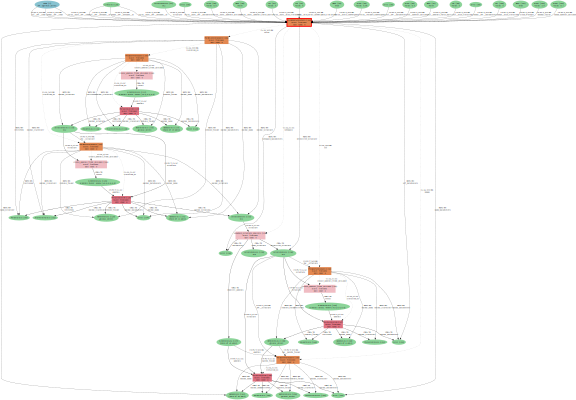

In [7]:
from aiida.tools.visualization import Graph

graph = Graph(graph_attr={"rankdir": "TB", "size": "8!,8!"})
graph.recurse_ancestors(result.node, annotate_links="both")
graph.recurse_descendants(result.node, annotate_links="both")
graph.graphviz

In [12]:
result.node.outputs.primitive_structure.get_pymatgen()

Structure Summary
Lattice
    abc : 3.875258079537184 3.875258079537184 3.875258079537184
 angles : 59.99999999999999 59.99999999999999 59.99999999999999
 volume : 41.151615904669846
      A : 0.0 2.7402212668887 2.7402212668887
      B : 2.7402212668887 0.0 2.7402212668887
      C : 2.7402212668887 2.7402212668887 0.0
PeriodicSite: Si (2.7402, 2.7402, 0.0000) [0.0000, 0.0000, 1.0000]
PeriodicSite: Si (4.1103, 1.3701, 4.1103) [0.2500, 1.2500, 0.2500]

In [13]:
result.node.outputs.band_structure

<BandsData: uuid: 8314b021-ef4e-47d7-b8bc-5f11d296216a (pk: 161)>